In [1]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
df_loan = pd.read_csv('loan.csv',dtype={'next_pymnt_d':'object'})
df_loan.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


Removing features with all NaN values and same values

In [2]:
df_loan = df_loan[df_loan.columns[df_loan.nunique() >1]]

Remove features high missing percentage(> 75%)

In [3]:
df_loan= df_loan[df_loan.columns[~(((df_loan.isnull().sum()/
                                     df_loan.shape[0])*100) > 75)]]

__Remove features not contributing to the decision:__
<br><br>

__1. customer behavior variables:__ The below behaviour variables are not available at the time of loan application, hence can not be used as predicatior for approval. ` delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv,  total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d`<br><br>
__2. ID's and Names:__ `id, member_id, url` (loan_id is the only unique info in url)

In [4]:
#dropping behavior features not available at the time of loan application
df_loan.drop(columns=['delinq_2yrs','earliest_cr_line','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','last_credit_pull_d'], inplace=True)

#dropping ID's and features containing such information
df_loan.drop(columns=['id', 'member_id', 'url'], inplace=True)

__Remove _current_ loan__: We do not have sufficient information current loans are going to be defaulted. Hence removing this entries.

In [5]:
df_loan = df_loan[df_loan.loan_status != 'Current']

In [6]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_amnt               38577 non-null  int64  
 1   funded_amnt             38577 non-null  int64  
 2   funded_amnt_inv         38577 non-null  float64
 3   term                    38577 non-null  object 
 4   int_rate                38577 non-null  object 
 5   installment             38577 non-null  float64
 6   grade                   38577 non-null  object 
 7   sub_grade               38577 non-null  object 
 8   emp_title               36191 non-null  object 
 9   emp_length              37544 non-null  object 
 10  home_ownership          38577 non-null  object 
 11  annual_inc              38577 non-null  float64
 12  verification_status     38577 non-null  object 
 13  issue_d                 38577 non-null  object 
 14  loan_status             38577 non-null

In [7]:
#feature transformations
#type convertion to
df_loan.int_rate = df_loan.int_rate.str.rstrip('%').astype('float64')
df_loan['int_rate_bins'] = pd.cut(df_loan.int_rate, bins=[5, 10, 15, 20, 25])
df_loan['dti_q4'] = pd.qcut(df_loan.dti, q=4)
df_loan['annual_inc_q4'] = pd.qcut(df_loan.annual_inc, q=4)
df_loan['prncp_rem'] = df_loan.funded_amnt_inv - df_loan.total_rec_prncp

In [8]:
df_bad = df_loan[df_loan.loan_status == 'Charged Off']

## Data analysis
***

### Univariate And Segmented Univariate Analysis

***
#### Analysis of the impact of number of monthly installments(term) on loan defaults

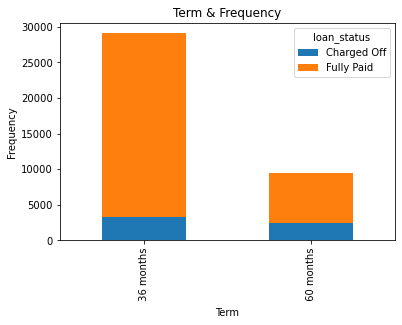

In [9]:
# Analysis of the number of monthly installments(term)
df_loan.groupby('term').loan_status.value_counts().unstack().plot.bar(stacked=True);
plt.title('Term & Frequency')
plt.xlabel('Term')
plt.ylabel('Frequency');


- Majority of the loans are issue with 36 months term.

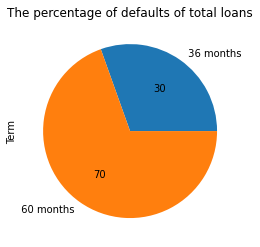

In [10]:
# ratio of term defaults with respect to total loan issued
((df_bad.term.value_counts(1))/(df_loan.term.value_counts(1))).plot.pie(autopct='%.0f');
plt.title('The percentage of defaults of total loans')
plt.ylabel('Term');

- Significantly high percent of the loan defaults from total loans are from 60 months term.

#### Analysis of the impact of interest rate(int_rate) on loan defaults

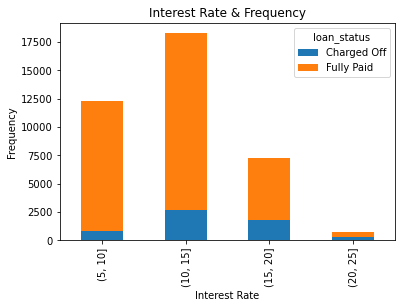

In [11]:
# Impact of interest rate on loan
df_loan.groupby('int_rate_bins').loan_status.value_counts().unstack().plot.bar(stacked=True);
plt.title('Interest Rate & Frequency')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency');

- Higher number of loans are issued between interest rate 5% to 15%

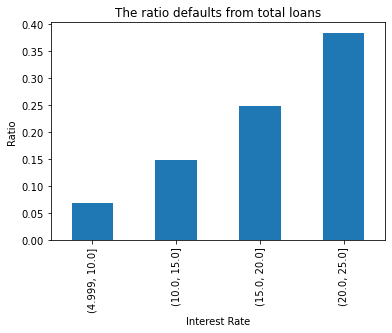

In [12]:
# ratio of interest rate defaults with respect to total loan issued 
((df_bad.int_rate.value_counts(bins=[5, 10, 15, 20, 25]))/(df_loan.int_rate.value_counts(bins=[5, 10, 15, 20, 25]))).plot.bar();
plt.title('The ratio defaults from total loans')
plt.xlabel('Interest Rate')
plt.ylabel('Ratio');

- There is gradual increase in defaults when the interest rate increases. Higher the interest rate, higher the precent of defaults.

#### Analysis of the impact of monthly instalment on loan defaults

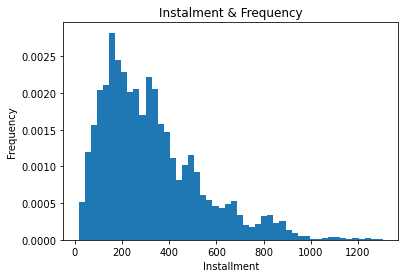

In [13]:
# Analysis of Instalment 
df_loan.installment.plot.hist(bins=50,density=True);
plt.title('Instalment & Frequency')
plt.xlabel('Installment')
plt.ylabel('Frequency');

- Majority of the instalments are between $150 - $350

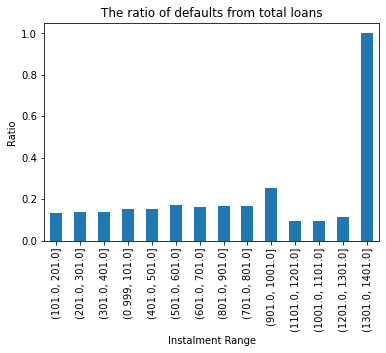

In [14]:
# ratio of installment category defaults with respect to total loan issued 
((df_bad.installment.value_counts(bins=range(1,int(df_loan.installment.max())+100, 100)))/
(df_loan.installment.value_counts(bins=range(1,int(df_loan.installment.max())+100,100)))).plot.bar();
plt.title('The ratio of defaults from total loans')
plt.xlabel('Instalment Range')
plt.ylabel('Ratio');

- 100% default(2 loan) for loan with installment amount between 1300-1400. 

#### Analysis of the impact of employment length in years on loan defaults

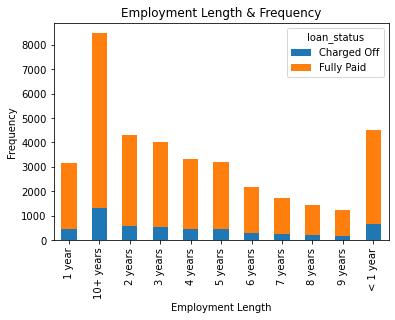

In [15]:
#Analysis of employment length
df_loan.groupby('emp_length').loan_status.value_counts().unstack().plot.bar(stacked=True);
plt.title('Employment Length & Frequency')
plt.xlabel('Employment Length')
plt.ylabel('Frequency');

- People with experience less 4 years and over 10 years are tend to take loans.

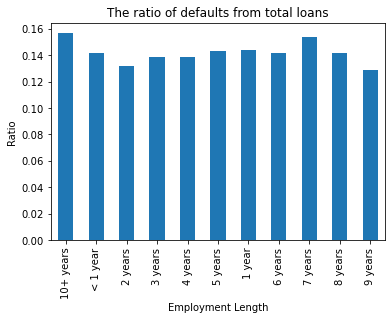

In [16]:
# ratio of defaults with respect to total loan issued 
#there are only minor variations in the % of defaulter across the employment lenght groups
((df_bad.emp_length.value_counts())/ (df_loan.emp_length.value_counts())).plot.bar();
plt.title('The ratio of defaults from total loans')
plt.xlabel('Employment Length')
plt.ylabel('Ratio');

- There is no significant difference in the ratio of defaults across difference employment groups

#### Analysis of the impact of home ownership on loan defaults

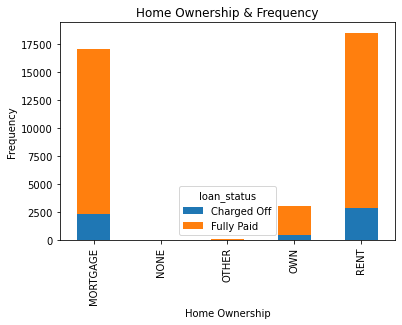

In [17]:
#Analysis of the impact of home ownership
df_loan.groupby('home_ownership').loan_status.value_counts().unstack().plot.bar(stacked=True);
plt.title('Home Ownership & Frequency')
plt.xlabel('Home Ownership')
plt.ylabel('Frequency');

- Higher number of loans are from people staying on RENT and MORTGATE.

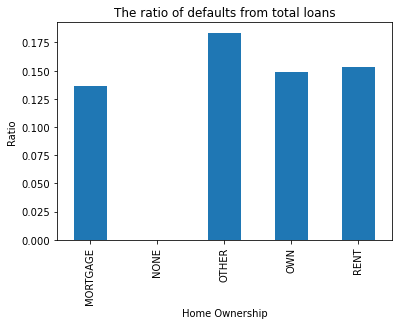

In [18]:
((df_bad.home_ownership.value_counts())/(df_loan.home_ownership.value_counts())).plot.bar();
plt.title('The ratio of defaults from total loans')
plt.xlabel('Home Ownership')
plt.ylabel('Ratio');

- There is no significant difference in ratio of default from this category.

#### Analysis of the impact of annual income on loan defaults

In [19]:
print("Overall Max Annual income: {}M,\nDefaulter Max Annual Income: {}M\n".
      format(df_loan.annual_inc.max()/10**6, df_bad.annual_inc.max()/10**6))
print(df_loan.annual_inc.describe(percentiles=[.25,.5,.75,.8]))

Overall Max Annual income: 6.0M,
Defaulter Max Annual Income: 1.25M

count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
80%      9.000000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64


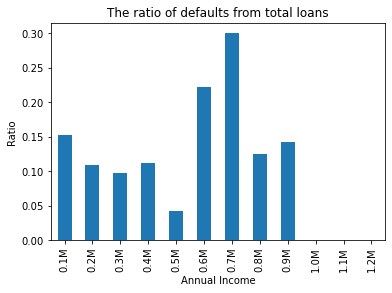

In [20]:
bin = [x for x in range(0,int(df_bad.annual_inc.max())+10000,100000)]
label = ["{}M".format(x/10**6) for x in bin]
((pd.cut(df_bad.annual_inc, bins=bin, labels=label[1:]).value_counts())/
 (pd.cut(df_loan.annual_inc, bins=bin, labels=label[1:]).value_counts())).plot(kind='bar');
plt.title('The ratio of defaults from total loans')
plt.xlabel('Annual Income')
plt.ylabel('Ratio');

- Most of the loan defaults are with annual income below $90K. Between annual income 1.25M to 6M all loans are fully paid. Loan with annual income of 50K to 70K are amoung the highest defaulters.

#### Analysis of the impact of income verification on loan defaults

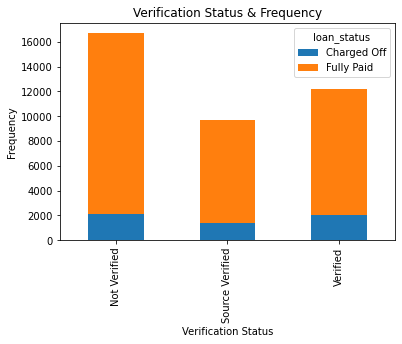

In [21]:
df_loan.groupby('verification_status').loan_status.value_counts().unstack().plot.bar(stacked=True);
plt.title('Verification Status & Frequency')
plt.xlabel('Verification Status')
plt.ylabel('Frequency');

- Most of the loan issues are not income verified.

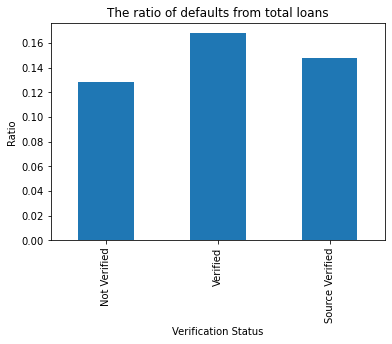

In [22]:
((df_bad.verification_status.value_counts())/df_loan.verification_status.value_counts()).plot(kind='bar');
plt.title('The ratio of defaults from total loans')
plt.xlabel('Verification Status')
plt.ylabel('Ratio');

- Verified and Source Verified has slightly higher fraction of defaults.

#### Analysis of the impact of purpose of loan on loan defaults

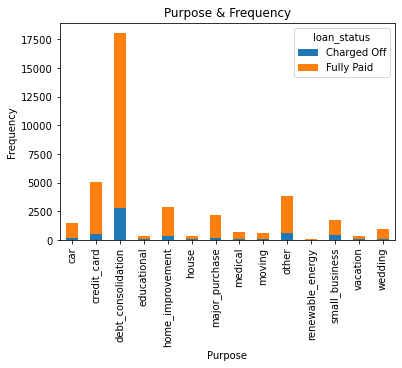

In [23]:
df_loan.groupby('purpose').loan_status.value_counts().unstack().plot.bar(stacked=True);
plt.title('Purpose & Frequency')
plt.xlabel('Purpose')
plt.ylabel('Frequency');

- nearly half of the entire loan issued are for debt consolidation

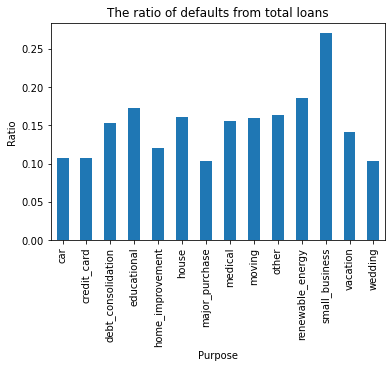

In [24]:
((df_bad.purpose.value_counts())/(df_loan.purpose.value_counts())).plot.bar();
plt.title('The ratio of defaults from total loans')
plt.xlabel('Purpose')
plt.ylabel('Ratio');

- Small Business has highest ratio of defaults

#### Analysis of the impact of Zip code on loan defaults

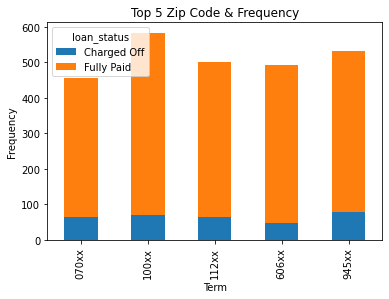

In [25]:
# The zip code where maximum loan issued
zip_code_max_loan=df_loan.zip_code.value_counts().sort_values(ascending=False).head(5).index
# Plot the distribution
df_loan[df_loan.zip_code.isin(zip_code_max_loan)].groupby('zip_code').loan_status.value_counts().unstack().plot.bar(stacked=True);
plt.title('Top 5 Zip Code & Frequency')
plt.xlabel('Term')
plt.ylabel('Frequency');

- Zip code 100xx is where the maximum loan issued. zip code 945xx is where maximum defaults happened among the max loan issued.

#### Analysis of the impact of State on loan defaults

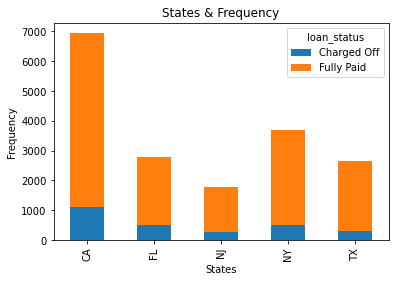

In [26]:
# Top 5 states where maximum loan issued
addr_state_max_loan=df_loan.addr_state.value_counts().sort_values(ascending=False).head(5).index
# Plot the distribution
df_loan[df_loan.addr_state.isin(addr_state_max_loan)].groupby('addr_state').loan_status.value_counts().unstack().plot.bar(stacked=True);
plt.title('States & Frequency')
plt.xlabel('States')
plt.ylabel('Frequency');

C:\Users\pvbij\AppData\Local\Temp/ipykernel_24000/3730056440.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ((df_bad[df_loan.addr_state.isin(addr_state_max_loan)].addr_state.value_counts())/


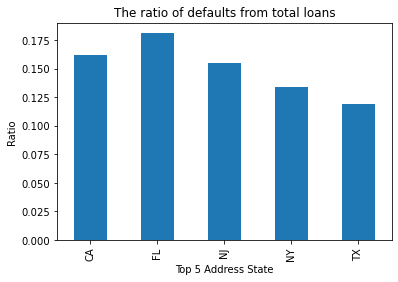

In [27]:
# Ratio of defaults from the top 5 states.
((df_bad[df_loan.addr_state.isin(addr_state_max_loan)].addr_state.value_counts())/
 (df_loan[df_loan.addr_state.isin(addr_state_max_loan)].addr_state.value_counts())).plot.bar();
plt.title('The ratio of defaults from total loans')
plt.xlabel('Top 5 Address State')
plt.ylabel('Ratio');

- FL and CA are the top two defaulters from the top 5 states.

#### Analysis of the impact of Debt to Income ratio on loan defaults

In [28]:
#summary of dti
df_loan.dti.describe()

count    38577.000000
mean        13.272727
std          6.673044
min          0.000000
25%          8.130000
50%         13.370000
75%         18.560000
max         29.990000
Name: dti, dtype: float64

In [29]:
df_bad.dti.describe()

count    5627.000000
mean       14.000624
std         6.585577
min         0.000000
25%         9.050000
50%        14.290000
75%        19.290000
max        29.850000
Name: dti, dtype: float64

- Majority of the loans are between dti 8% and 19%, and Majority of the defaults are bet 9% and 19%

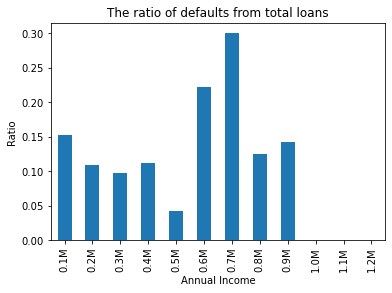

In [30]:
bin = [x for x in range(0,int(df_bad.annual_inc.max())+10000,100000)]
label = ["{}M".format(x/10**6) for x in bin]
((pd.cut(df_bad.annual_inc, bins=bin, labels=label[1:]).value_counts())/
 (pd.cut(df_loan.annual_inc, bins=bin, labels=label[1:]).value_counts())).plot(kind='bar');
plt.title('The ratio of defaults from total loans')
plt.xlabel('Annual Income')
plt.ylabel('Ratio');

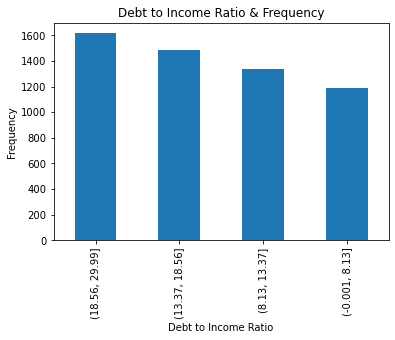

In [31]:
df_bad.dti_q4.value_counts().plot.bar();
plt.title('Debt to Income Ratio & Frequency')
plt.xlabel('Debt to Income Ratio')
plt.ylabel('Frequency');

- higher dti loans are defaulted the most.

***
### Bivariate Analysis 

#### Analysis of the total principle lost vs purpose

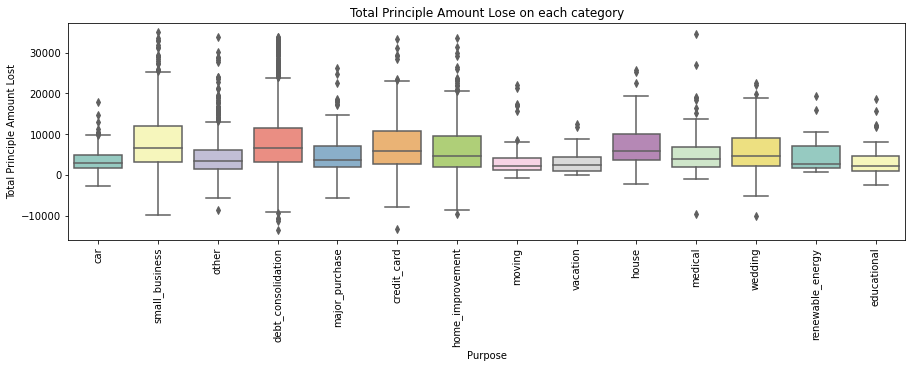

In [32]:
plt.figure(figsize=(15,4))
sns.boxplot(x="purpose", y="prncp_rem", 
                   data=df_bad, palette="Set3")

plt.title('Total Principle Amount Lose on each category')
plt.xlabel('Purpose')
plt.ylabel('Total Principle Amount Lost')
plt.xticks(rotation=90);  

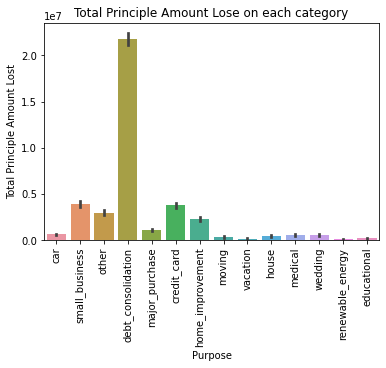

In [33]:
sns.barplot(x="purpose", y="prncp_rem", data=df_bad,estimator=sum)

plt.title('Total Principle Amount Lose on each category')
plt.xlabel('Purpose')
plt.ylabel('Total Principle Amount Lost')
plt.xticks(rotation=90);

- Loan for Debt Consolidation is the highest lose making business.

#### Analysis of the total principle lost vs Home ownership

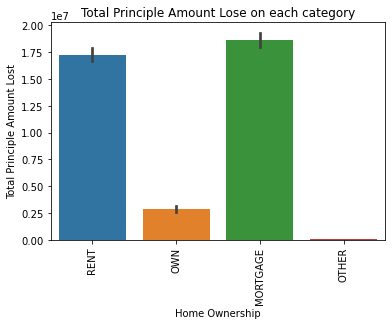

In [34]:
sns.barplot(x="home_ownership", y="prncp_rem", data=df_bad,estimator=sum)

plt.title('Total Principle Amount Lose on each category')
plt.xlabel('Home Ownership')
plt.ylabel('Total Principle Amount Lost')
plt.xticks(rotation=90);

- It is safe to give loan with people staying their own home.

#### Analysis of the total principle lost vs Address State

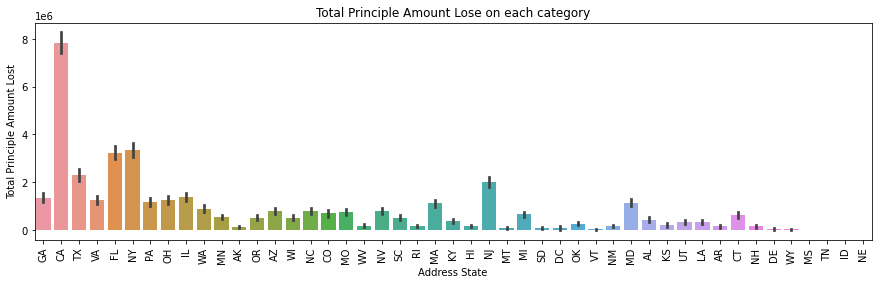

In [35]:
plt.figure(figsize=(15,4))
sns.barplot(x="addr_state", y="prncp_rem", data=df_bad, estimator=sum)

plt.title('Total Principle Amount Lose on each category')
plt.xlabel('Address State')
plt.ylabel('Total Principle Amount Lost')
plt.xticks(rotation=90);

- CA, NY, and FL contributed highest lose.

#### Analysis of the total principle lost vs Income verification

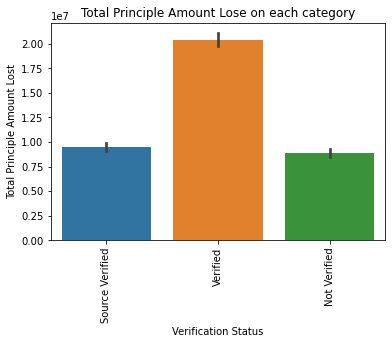

In [36]:
sns.barplot(x="verification_status", y="prncp_rem", data=df_bad, estimator=sum)

plt.title('Total Principle Amount Lose on each category')
plt.xlabel('Verification Status')
plt.ylabel('Total Principle Amount Lost')
plt.xticks(rotation=90);

- Income Verification seem not thorough

#### Analysis of the total principle lost vs Grade

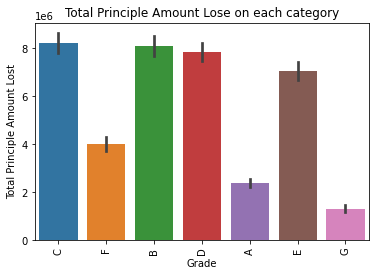

In [37]:
sns.barplot(x="grade", y="prncp_rem", data=df_bad, estimator=sum)

plt.title('Total Principle Amount Lose on each category')
plt.xlabel('Grade')
plt.ylabel('Total Principle Amount Lost')
plt.xticks(rotation=90);

- Grade A, G and F relatively are better borrowers.